# FDNY Response-Time Descriptive Analysis

Incident Data: https://data.cityofnewyork.us/Public-Safety/EMS-Incident-Dispatch-Data/76xm-jjuj

Zip Code Boundaries: https://data.cityofnewyork.us/Business/Zip-Code-Boundaries/i8iw-xf4u

In [1]:
import os
import numpy as np
import pandas as pd
import geopandas as gpd
import feather

import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.colors as colors
plt.rcParams.update({'font.size': 13})

import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

%matplotlib inline

In [2]:
data_path = os.getenv('DATA_PATH')
data_path

'/home/jovyan/data'

In [3]:
%time df = feather.read_dataframe(data_path + '/ems_incidents.feather')

CPU times: user 5.98 s, sys: 6.61 s, total: 12.6 s
Wall time: 1min 12s


Maybe don't use records with invalid times?

In [4]:
df.VALID_DISPATCH_RSPNS_TIME_INDC = df.VALID_DISPATCH_RSPNS_TIME_INDC.apply(lambda x: x == b'Y')
df.VALID_INCIDENT_RSPNS_TIME_INDC = df.VALID_INCIDENT_RSPNS_TIME_INDC.apply(lambda x: x == b'Y')
(~df.VALID_DISPATCH_RSPNS_TIME_INDC | ~df.VALID_INCIDENT_RSPNS_TIME_INDC).sum() / len(df)

0.03208516907521611

In [5]:
df = df.loc[(df.VALID_DISPATCH_RSPNS_TIME_INDC & df.VALID_INCIDENT_RSPNS_TIME_INDC),:]

In [6]:
df.head()

,CAD_INCIDENT_ID,INCIDENT_DATETIME,INITIAL_CALL_TYPE,INITIAL_SEVERITY_LEVEL_CODE,FINAL_CALL_TYPE,FINAL_SEVERITY_LEVEL_CODE,FIRST_ASSIGNMENT_DATETIME,VALID_DISPATCH_RSPNS_TIME_INDC,DISPATCH_RESPONSE_SECONDS_QY,FIRST_ACTIVATION_DATETIME,...,assigment_time,activation_time,travel_to_scene_time,on_scene_time,travel_to_hospital_time,at_hospital_time,year,month,day_of_week,hour
0,130010001,2013-01-01 00:00:04,b'RESPIR',4,b'RESPIR',4,2013-01-01 00:01:45,True,101,2013-01-01 00:01:51,...,101.0,6.0,690.0,928.0,566.0,1601.0,2013,1,1,0
1,130010002,2013-01-01 00:00:19,b'CARD',3,b'CARD',3,2013-01-01 00:01:18,True,59,2013-01-01 00:02:08,...,59.0,50.0,742.0,NaN,NaN,NaN,2013,1,1,0
2,130010004,2013-01-01 00:01:04,b'ARREST',1,b'ARREST',1,2013-01-01 00:01:33,True,29,2013-01-01 00:01:58,...,29.0,25.0,375.0,NaN,NaN,NaN,2013,1,1,0
3,130010005,2013-01-01 00:01:16,b'SICK',6,b'SICK',6,2013-01-01 00:02:12,True,56,2013-01-01 00:02:55,...,56.0,43.0,729.0,1190.0,1088.0,1646.0,2013,1,1,0
4,130010006,2013-01-01 00:01:26,b'INJURY',5,b'INJURY',5,2013-01-01 00:01:58,True,32,2013-01-01 00:02:55,...,32.0,57.0,767.0,720.0,211.0,1319.0,2013,1,1,0


In [7]:
zips = gpd.read_file(data_path + '/ZIP_CODE_040114/ZIP_CODE_040114.shp')
zips = zips.loc[zips.BLDGZIP == '0',['ZIPCODE', 'BLDGZIP', 'POPULATION', 'AREA', 'geometry']] 
zips.head()

,ZIPCODE,BLDGZIP,POPULATION,AREA,geometry
0,11436,0,18681.0,2.269930e+07,"POLYGON ((1038098.251871482 188138.3800067157,..."
1,11213,0,62426.0,2.963100e+07,"POLYGON ((1001613.712964058 186926.4395172149,..."
2,11212,0,83866.0,4.197210e+07,"POLYGON ((1011174.275535807 183696.33770971, 1..."
3,11225,0,56527.0,2.369863e+07,"POLYGON ((995908.3654508889 183617.6128015518,..."
4,11218,0,72280.0,3.686880e+07,"POLYGON ((991997.1134308875 176307.4958601296,..."


## Clustering response time timeseries by Zip Code with K-Means

Reshape data and get quarterly mean response time for each Zip Code

In [77]:
#group by zipcode
df_respose_by_zip = df.set_index('INCIDENT_DATETIME').loc[:,['INCIDENT_RESPONSE_SECONDS_QY','ZIPCODE']].groupby('ZIPCODE')\
                                    .resample('Q').mean()[['INCIDENT_RESPONSE_SECONDS_QY']].reset_index()\
                                    .pivot(index='ZIPCODE', columns='INCIDENT_DATETIME', values='INCIDENT_RESPONSE_SECONDS_QY')
df_respose_by_zip.head()

INCIDENT_DATETIME,2013-03-31 00:00:00,2013-06-30 00:00:00,2013-09-30 00:00:00,2013-12-31 00:00:00,2014-03-31 00:00:00,2014-06-30 00:00:00,2014-09-30 00:00:00,2014-12-31 00:00:00,2015-03-31 00:00:00,2015-06-30 00:00:00,...,2016-09-30 00:00:00,2016-12-31 00:00:00,2017-03-31 00:00:00,2017-06-30 00:00:00,2017-09-30 00:00:00,2017-12-31 00:00:00,2018-03-31 00:00:00,2018-06-30 00:00:00,2018-09-30 00:00:00,2018-12-31 00:00:00
ZIPCODE,,,,,,,,,,,,,,,,,,,,,
83.0,NaN,NaN,420.000000,NaN,NaN,669.000000,670.000000,617.000000,NaN,NaN,...,534.000000,NaN,712.500000,274.000000,1783.000000,NaN,954.000000,759.000000,NaN,NaN
10000.0,445.625000,909.161290,690.931034,1320.464286,577.187500,674.891892,577.333333,813.320000,2421.058824,589.378378,...,523.465517,1018.531915,937.500000,636.428571,590.185185,1321.833333,853.428571,917.452381,953.191489,930.625000
10001.0,632.938756,702.265991,616.497449,638.926674,589.982456,608.999722,537.396566,678.203577,655.174945,696.781637,...,597.736943,572.241728,566.765994,574.595374,548.186338,591.751569,677.757365,630.903204,663.311190,644.930367
10002.0,568.494541,599.508929,524.057923,531.244103,501.506245,507.404961,477.351691,594.754878,542.720196,570.768152,...,515.357362,481.807720,479.016785,479.591895,465.500119,496.915976,520.176101,566.676761,586.151713,550.657155
10003.0,524.514110,533.309710,483.003651,520.097966,469.402461,480.251990,430.650342,553.274992,503.506658,554.396467,...,474.815226,465.089422,475.678487,441.692060,430.768210,461.643240,513.518741,525.669956,521.018144,517.462559


Drop Zip Codes with no incidents in at least one quarter

In [78]:
print(df_respose_by_zip.shape)
df_respose_by_zip.dropna(inplace=True)
print(df_respose_by_zip.shape)

(237, 24)
(195, 24)


Scale each time series (mean=0, std=1). When using K-Means we will get clusters with similar timeseries shape.

In [79]:
df_respose_by_zip_scaled = ((df_respose_by_zip.T - df_respose_by_zip.mean(axis=1))/df_respose_by_zip.std(axis=1)).T
df_respose_by_zip_scaled.head()

INCIDENT_DATETIME,2013-03-31 00:00:00,2013-06-30 00:00:00,2013-09-30 00:00:00,2013-12-31 00:00:00,2014-03-31 00:00:00,2014-06-30 00:00:00,2014-09-30 00:00:00,2014-12-31 00:00:00,2015-03-31 00:00:00,2015-06-30 00:00:00,...,2016-09-30 00:00:00,2016-12-31 00:00:00,2017-03-31 00:00:00,2017-06-30 00:00:00,2017-09-30 00:00:00,2017-12-31 00:00:00,2018-03-31 00:00:00,2018-06-30 00:00:00,2018-09-30 00:00:00,2018-12-31 00:00:00
ZIPCODE,,,,,,,,,,,,,,,,,,,,,
10000.0,-1.062648,0.008213,-0.495943,0.958405,-0.758713,-0.532996,-0.758376,-0.213200,3.500997,-0.730550,...,-0.882821,0.260881,0.073681,-0.621854,-0.728686,0.961567,-0.120541,0.027367,0.109931,0.057798
10001.0,0.156670,1.542251,-0.171928,0.276345,-0.701859,-0.321778,-1.752846,1.061337,0.601085,1.432640,...,-0.546877,-1.056427,-1.165866,-1.009387,-1.537201,-0.666501,1.052419,0.115987,0.763697,0.396335
10002.0,0.962361,1.716328,-0.117904,0.056794,-0.666141,-0.522742,-1.253344,1.600756,0.335780,1.017633,...,-0.329417,-1.145017,-1.212865,-1.198884,-1.541458,-0.777731,-0.212272,0.918170,1.391611,0.528730
10003.0,0.638744,0.869384,-0.449754,0.522942,-0.806408,-0.521909,-1.822577,1.392919,0.087881,1.422327,...,-0.664473,-0.919506,-0.641837,-1.533038,-1.819486,-1.009873,0.350420,0.669053,0.547072,0.453836
10004.0,-0.261857,0.864454,0.981727,-0.073001,-0.723209,0.505366,-1.296541,0.322257,-0.229091,2.748926,...,-0.041516,-1.177876,-0.684162,-0.519548,-1.666497,0.602716,-0.604528,-0.172288,1.271718,0.366972


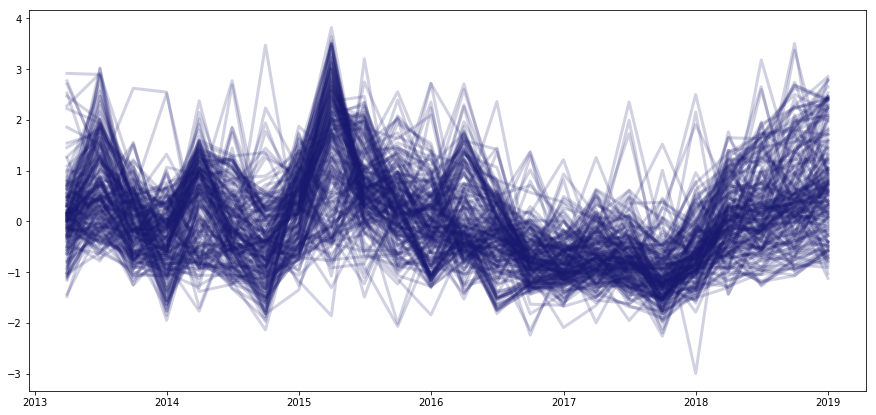

In [80]:
fig = plt.figure(figsize=(15,7))
ax = fig.add_subplot(111)

data_columns = df_respose_by_zip_scaled.columns

for ind, row in df_respose_by_zip_scaled.iterrows():
    ax.plot(data_columns, row.values, color='midnightblue', alpha=0.2, lw=3)

**Note:** Looks decreasing to me...

#### Clustering with K-Means

Find the best number of clusters

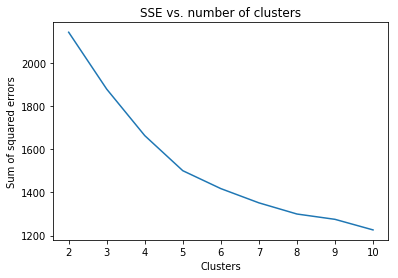

In [81]:
SSE = []
range_n_clusters = range(2,11)
for i in range_n_clusters:
    km = KMeans(n_clusters = i)
    res=km.fit(df_respose_by_zip_scaled)
    SSE.append(res.inertia_)

plt.gca()
plt.plot(range_n_clusters,SSE)
plt.xlabel("Clusters")
plt.ylabel("Sum of squared errors")
plt.title("SSE vs. number of clusters")
plt.show()

**Note:** Not a clear 'elbow'. 4 or 5?

In [82]:
for n_clusters in range_n_clusters:  
    km = KMeans(n_clusters = i)
    res=km.fit(df_respose_by_zip_scaled)
    silhouette_avg = silhouette_score(df_respose_by_zip_scaled, res.labels_)
    print("For n_clusters = {},".format(n_clusters)+" the average silhouette_score is : {}".format(silhouette_avg))

For n_clusters = 2, the average silhouette_score is : 0.1974363203485577
For n_clusters = 3, the average silhouette_score is : 0.21354821194016774
For n_clusters = 4, the average silhouette_score is : 0.19334548265195922
For n_clusters = 5, the average silhouette_score is : 0.19460299022139824
For n_clusters = 6, the average silhouette_score is : 0.2073871932644739
For n_clusters = 7, the average silhouette_score is : 0.19234337199541018
For n_clusters = 8, the average silhouette_score is : 0.18330636597891503
For n_clusters = 9, the average silhouette_score is : 0.23030864961268374
For n_clusters = 10, the average silhouette_score is : 0.22160486069068508


In [83]:
#Number of clusters
nc = 5

#cluster with kmeans
km = KMeans(n_clusters=nc, random_state=444).fit(df_respose_by_zip_scaled)

#Add to dataframe
df_respose_by_zip_scaled['kmeans'] = km.labels_ + 1
df_respose_by_zip['kmeans'] = km.labels_ + 1

km.labels_.shape

(195,)

Merge with shapefile for mapping

In [84]:
df_respose_by_zip_scaled.index = df_respose_by_zip_scaled.index.astype(int)
zips.ZIPCODE = zips.ZIPCODE.astype(int)

df_respose_by_zip_shp = zips.merge(df_respose_by_zip_scaled, left_on='ZIPCODE', right_index=True, how='left')

#Add 0 for the zipcodes that were not clustered
df_respose_by_zip_shp.fillna(0, inplace=True)

#### Plot clusters on map

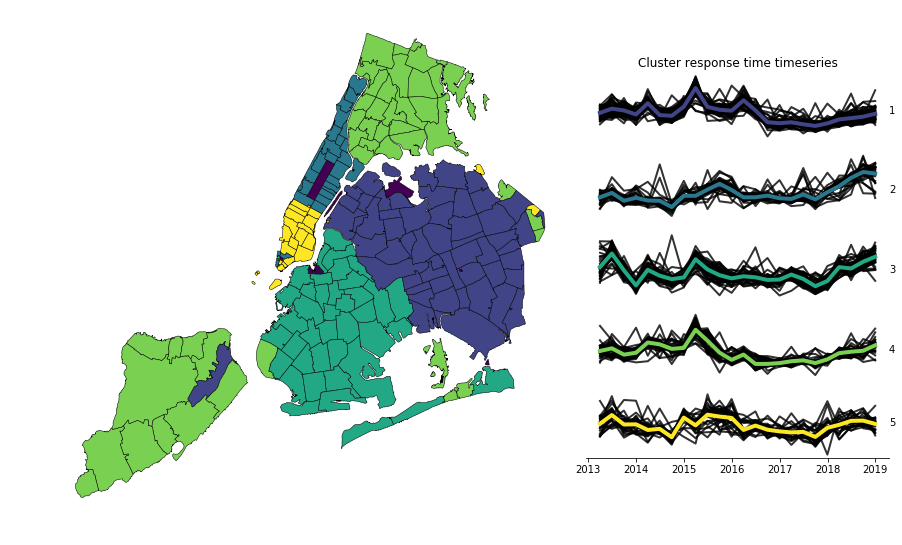

In [85]:
#Plot a map and the clustered time series
cmap = cm.get_cmap('viridis')
cmap.set_bad((1, 1, 1, 1))
fig = plt.figure(figsize=(15,10))

for i in range(nc):
    
    cluster = df_respose_by_zip_scaled.loc[df_respose_by_zip_scaled.kmeans == (i+1),data_columns]
    
    ax = plt.subplot2grid((nc+2, 8), (i+1, 5), colspan=3)
    
    if i == 0:
        ax.set_title("Cluster response time timeseries")
    
    for row, values in cluster.iterrows():
        
        ax.plot(data_columns, values, 'k-', alpha=0.8, lw=2)
        
    ax.plot(data_columns, cluster.mean(axis=0).values, '-', lw=4, color=cmap((i+1)/nc))
    
    ax.annotate(s='{}'.format(i+1), xy=(ax.get_xlim()[1],0))

    ax.axis('off')
    
    if i == nc-1:
        ax.axis('on')
        ax.spines['right'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.set_yticks([])

ax = plt.subplot2grid((nc+2, 8), (0, 0), colspan=5, rowspan=9)

df_respose_by_zip_shp.plot(column='kmeans', ax=ax, cmap=cmap, edgecolor='k', lw=0.5)

ax.axis('off')

plt.savefig('images/resp_time_clusters.png')
plt.show()

**Note:** Zip Codes almost perfectly clustered by Borough. This can point to organizational structure and staffing accross boroughs as an important factor behind emergency response times.

#### Descriptive statistics by cluster

In [86]:
df_respose_by_zip.head()

INCIDENT_DATETIME,2013-03-31 00:00:00,2013-06-30 00:00:00,2013-09-30 00:00:00,2013-12-31 00:00:00,2014-03-31 00:00:00,2014-06-30 00:00:00,2014-09-30 00:00:00,2014-12-31 00:00:00,2015-03-31 00:00:00,2015-06-30 00:00:00,...,2016-12-31 00:00:00,2017-03-31 00:00:00,2017-06-30 00:00:00,2017-09-30 00:00:00,2017-12-31 00:00:00,2018-03-31 00:00:00,2018-06-30 00:00:00,2018-09-30 00:00:00,2018-12-31 00:00:00,kmeans
ZIPCODE,,,,,,,,,,,,,,,,,,,,,
10000.0,445.625000,909.161290,690.931034,1320.464286,577.187500,674.891892,577.333333,813.320000,2421.058824,589.378378,...,1018.531915,937.500000,636.428571,590.185185,1321.833333,853.428571,917.452381,953.191489,930.625000,1
10001.0,632.938756,702.265991,616.497449,638.926674,589.982456,608.999722,537.396566,678.203577,655.174945,696.781637,...,572.241728,566.765994,574.595374,548.186338,591.751569,677.757365,630.903204,663.311190,644.930367,5
10002.0,568.494541,599.508929,524.057923,531.244103,501.506245,507.404961,477.351691,594.754878,542.720196,570.768152,...,481.807720,479.016785,479.591895,465.500119,496.915976,520.176101,566.676761,586.151713,550.657155,5
10003.0,524.514110,533.309710,483.003651,520.097966,469.402461,480.251990,430.650342,553.274992,503.506658,554.396467,...,465.089422,475.678487,441.692060,430.768210,461.643240,513.518741,525.669956,521.018144,517.462559,5
10004.0,590.659824,668.492925,676.596950,603.710583,558.778364,643.678351,519.158607,631.024664,592.924078,798.718232,...,527.358824,561.476673,572.852201,493.592972,650.405660,566.979719,596.849415,696.636646,634.114679,5


In [90]:
df_respose_by_zip['pct_change'] = df_respose_by_zip.iloc[:,-2]/df_respose_by_zip.iloc[:,0]*100

In [98]:
cols = ['incident_time','assigment_time', 'activation_time', 'travel_to_scene_time', 'on_scene_time', 'travel_to_hospital_time', 'at_hospital_time']
df_clusters = df.groupby('ZIPCODE')[cols].agg(['mean', 'count']).merge(df_respose_by_zip[['kmeans', 'pct_change']], right_index=True, left_index=True)
df_clusters.head()

/opt/conda/lib/python3.6/site-packages/pandas/core/reshape/merge.py:544: UserWarning: merging between different levels can give an unintended result (2 levels on the left, 1 on the right)
  warnings.warn(msg, UserWarning)


,"(incident_time, mean)","(incident_time, count)","(assigment_time, mean)","(assigment_time, count)","(activation_time, mean)","(activation_time, count)","(travel_to_scene_time, mean)","(travel_to_scene_time, count)","(on_scene_time, mean)","(on_scene_time, count)","(travel_to_hospital_time, mean)","(travel_to_hospital_time, count)","(at_hospital_time, mean)","(at_hospital_time, count)",kmeans,pct_change
ZIPCODE,,,,,,,,,,,,,,,,
10000.0,3789.621336,853,264.128957,853,26.363423,853,568.166471,853,1469.233945,436,749.649412,425,1867.663529,425,1,208.835905
10001.0,3553.958434,97171,122.711868,97202,23.672706,97087,479.856376,97087,1257.333714,63959,790.237713,63463,1771.139078,63439,5,101.894593
10002.0,3583.253588,97765,91.350174,97797,21.640624,97700,415.862610,97700,1302.513956,69144,630.962830,68792,1850.809128,68779,5,96.862347
10003.0,3196.827286,83977,98.444820,84007,21.348366,83883,380.788980,83883,1215.072685,53945,523.075262,53626,1834.405313,53608,5,98.655603
10004.0,3614.259067,12684,132.186096,12687,21.632540,12649,456.261444,12649,1226.660438,8723,621.165382,8689,1895.953614,8688,5,107.357002


In [102]:
df_clusters.columns = ["_".join(c) for c in df_clusters.columns[:-2]] + list(df_clusters.columns[-2:])

In [103]:
list(df_clusters.columns[:2])

['incident_time_mean', 'incident_time_count']

In [104]:
list(df_clusters.columns[2::2])

['assigment_time_mean',
 'activation_time_mean',
 'travel_to_scene_time_mean',
 'on_scene_time_mean',
 'travel_to_hospital_time_mean',
 'at_hospital_time_mean',
 'kmeans']

In [105]:
keep = list(df_clusters.columns[:2]) + list(df_clusters.columns[2::2]) + [df_clusters.columns[-1]])
df_clusters = df_clusters.loc[:,keep]
df_clusters.head()

/opt/conda/lib/python3.6/site-packages/pandas/core/indexing.py:1472: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


,incident_time_mean,incident_time_count,assigment_time_meanpct_change,activation_time_meanpct_change,travel_to_scene_time_meanpct_change,on_scene_time_meanpct_change,travel_to_hospital_time_meanpct_change,at_hospital_time_meanpct_change,kmeanspct_change
ZIPCODE,,,,,,,,,
10000.0,3789.621336,853,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10001.0,3553.958434,97171,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10002.0,3583.253588,97765,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10003.0,3196.827286,83977,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10004.0,3614.259067,12684,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [42]:
df_clusters.sort_values('incident_time_mean').tail()

,incident_time_mean,incident_time_count,assigment_time_mean,activation_time_mean,travel_to_scene_time_mean,on_scene_time_mean,travel_to_hospital_time_mean,at_hospital_time_mean,kmeans
ZIPCODE,,,,,,,,,
10475,4588.722124,39766,93.140078,25.131583,502.923042,1549.706032,852.568152,2259.383738,4
11208,4612.567588,120850,103.221462,20.666476,637.171922,1199.081045,1098.458523,2237.235313,3
11239,4792.831593,17713,71.084086,21.026540,581.427862,1591.404616,1025.020268,2312.592931,3
11370,5381.895170,28532,46.747136,23.759913,474.438171,2516.300462,975.294578,1973.773870,1
11359,36980.745313,2187,233.184018,31.605685,40.557542,1724.704787,1163.435484,2774.685484,5


In [49]:
df_clusters_mod = df_clusters.loc[df_clusters.index != 11359,:]
df_clusters_mod.sort_values('incident_time_count').tail()

,incident_time_mean,incident_time_count,assigment_time_mean,activation_time_mean,travel_to_scene_time_mean,on_scene_time_mean,travel_to_hospital_time_mean,at_hospital_time_mean,kmeans
ZIPCODE,,,,,,,,,
11208,4612.567588,120850,103.221462,20.666476,637.171922,1199.081045,1098.458523,2237.235313,3
10457,4038.323736,135450,144.229670,27.159571,448.644128,1270.221129,575.818104,2165.064987,4
11212,4088.817805,139576,83.229843,21.554531,454.856411,1238.996078,653.962561,2259.352114,3
11207,4295.093355,151518,89.358651,21.441285,524.827116,1187.289778,901.469142,2258.220973,3
10456,4202.220689,159564,146.930624,28.493360,468.250266,1315.884705,750.962551,2111.941705,4


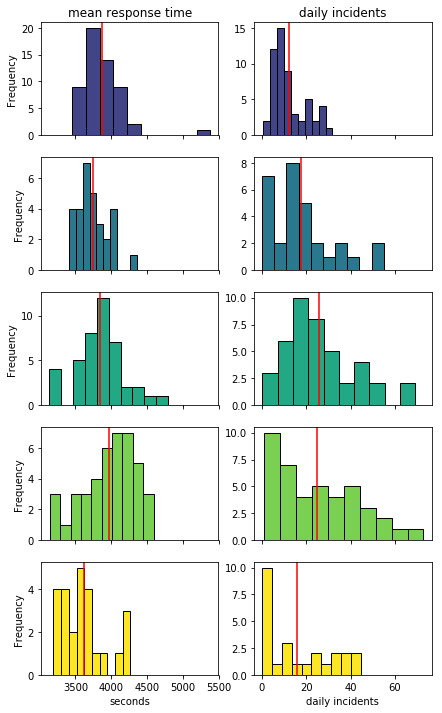

In [66]:
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(7,12), sharex='col')
#plt.subplots_adjust(wspace=0.5)

days = df.INCIDENT_DATETIME.dt.date.nunique()

for k in range(1,6):
    ax = axes[k-1][0]
    
    if k == 1:
        ax.set_title('mean response time')
    elif k == 5:
        ax.set_xlabel('seconds')
    
    df_clusters_mod[df_clusters_mod.kmeans==k].incident_time_mean.plot.hist(ax=ax, color=cmap(k/nc), edgecolor='k')
    ax.axvline(x=df_clusters_mod[df_clusters_mod.kmeans==k].incident_time_mean.mean(), color='r')
    
    ax = axes[k-1][1]
    
    if k == 1:
        ax.set_title('daily incidents')
    elif k == 5:
        ax.set_xlabel('daily incidents')
        
    
    (df_clusters_mod[df_clusters_mod.kmeans==k].incident_time_count/days).plot.hist(ax=ax, color=cmap(k/nc), edgecolor='k')
    ax.axvline(x=(df_clusters_mod[df_clusters_mod.kmeans==k].incident_time_count/days).mean(), color='r')
    
    ax.set_ylabel('')
    
plt.savefig('images/cluster_stats.png')
plt.show()

## Incidents by time of day

In [8]:
df.columns

Index(['CAD_INCIDENT_ID', 'INCIDENT_DATETIME', 'INITIAL_CALL_TYPE',
       'INITIAL_SEVERITY_LEVEL_CODE', 'FINAL_CALL_TYPE',
       'FINAL_SEVERITY_LEVEL_CODE', 'FIRST_ASSIGNMENT_DATETIME',
       'VALID_DISPATCH_RSPNS_TIME_INDC', 'DISPATCH_RESPONSE_SECONDS_QY',
       'FIRST_ACTIVATION_DATETIME', 'FIRST_ON_SCENE_DATETIME',
       'VALID_INCIDENT_RSPNS_TIME_INDC', 'INCIDENT_RESPONSE_SECONDS_QY',
       'INCIDENT_TRAVEL_TM_SECONDS_QY', 'FIRST_TO_HOSP_DATETIME',
       'FIRST_HOSP_ARRIVAL_DATETIME', 'INCIDENT_CLOSE_DATETIME',
       'HELD_INDICATOR', 'INCIDENT_DISPOSITION_CODE', 'BOROUGH', 'ATOM',
       'INCIDENT_DISPATCH_AREA', 'ZIPCODE', 'POLICEPRECINCT',
       'CITYCOUNCILDISTRICT', 'COMMUNITYDISTRICT', 'COMMUNITYSCHOOLDISTRICT',
       'CONGRESSIONALDISTRICT', 'REOPEN_INDICATOR', 'SPECIAL_EVENT_INDICATOR',
       'STANDBY_INDICATOR', 'TRANSFER_INDICATOR', 'incident_time',
       'assigment_time', 'activation_time', 'travel_to_scene_time',
       'on_scene_time', 'travel_to_hospital

In [9]:
resptime_cols = ['assigment_time', 'activation_time', 'travel_to_scene_time', 'on_scene_time', 'travel_to_hospital_time', 'at_hospital_time']

#df_time_cycles = df.set_index('INCIDENT_DATETIME').loc[:,resptime_cols+['ZIPCODE']]
#df_time_cycles['hour'] = df_time_cycles.index.hour
#df_time_cycles['weekday'] = df_time_cycles.index.weekday
#df_time_cycles['weekday_name'] = df_time_cycles.index.weekday_name
df['weekend'] = df['day_of_week'].apply(lambda x: x>4)
df.head()
#df_time_cycles.head()

,CAD_INCIDENT_ID,INCIDENT_DATETIME,INITIAL_CALL_TYPE,INITIAL_SEVERITY_LEVEL_CODE,FINAL_CALL_TYPE,FINAL_SEVERITY_LEVEL_CODE,FIRST_ASSIGNMENT_DATETIME,VALID_DISPATCH_RSPNS_TIME_INDC,DISPATCH_RESPONSE_SECONDS_QY,FIRST_ACTIVATION_DATETIME,...,activation_time,travel_to_scene_time,on_scene_time,travel_to_hospital_time,at_hospital_time,year,month,day_of_week,hour,weekend
0,130010001,2013-01-01 00:00:04,b'RESPIR',4,b'RESPIR',4,2013-01-01 00:01:45,True,101,2013-01-01 00:01:51,...,6.0,690.0,928.0,566.0,1601.0,2013,1,1,0,False
1,130010002,2013-01-01 00:00:19,b'CARD',3,b'CARD',3,2013-01-01 00:01:18,True,59,2013-01-01 00:02:08,...,50.0,742.0,NaN,NaN,NaN,2013,1,1,0,False
2,130010004,2013-01-01 00:01:04,b'ARREST',1,b'ARREST',1,2013-01-01 00:01:33,True,29,2013-01-01 00:01:58,...,25.0,375.0,NaN,NaN,NaN,2013,1,1,0,False
3,130010005,2013-01-01 00:01:16,b'SICK',6,b'SICK',6,2013-01-01 00:02:12,True,56,2013-01-01 00:02:55,...,43.0,729.0,1190.0,1088.0,1646.0,2013,1,1,0,False
4,130010006,2013-01-01 00:01:26,b'INJURY',5,b'INJURY',5,2013-01-01 00:01:58,True,32,2013-01-01 00:02:55,...,57.0,767.0,720.0,211.0,1319.0,2013,1,1,0,False


In [36]:
df.INCIDENT_DATETIME.dt.date.nunique()

2191

In [11]:
df_time_of_day = df.groupby('hour')[resptime_cols]\
                                .agg(['mean','count'])
df_time_of_day.columns = ['_'.join(col).strip() for col in df_time_of_day.columns.values]
df_time_of_day.rename(columns={'assigment_time_count':'total_incidents'}, inplace=True)
df_time_of_day['average_incidents'] = df_time_of_day['total_incidents']/df.INCIDENT_DATETIME.dt.date.nunique()
df_time_of_day.head()

,assigment_time_mean,total_incidents,activation_time_mean,activation_time_count,travel_to_scene_time_mean,travel_to_scene_time_count,on_scene_time_mean,on_scene_time_count,travel_to_hospital_time_mean,travel_to_hospital_time_count,at_hospital_time_mean,at_hospital_time_count,average_incidents
hour,,,,,,,,,,,,,
0,211.931335,297358,22.277646,297036,410.955925,297036,1157.447173,207385,577.095339,206033,2017.948663,205740,135.717937
1,81.543877,257547,22.323000,257263,399.838698,257263,1151.222998,182073,561.128961,180365,2033.240822,179319,117.547695
2,73.650610,224563,20.672061,224307,400.156803,224307,1156.856601,159234,554.135504,158239,2063.336700,158206,102.493382
3,62.301415,200418,19.600514,200187,397.802050,200187,1172.560687,143367,557.873263,142523,2071.029967,142522,91.473300
4,52.138527,186809,19.534928,186584,397.261159,186584,1201.185755,133170,565.112471,132434,2047.049134,132434,85.261981


#### Plot mean response time and average incidents by time of day

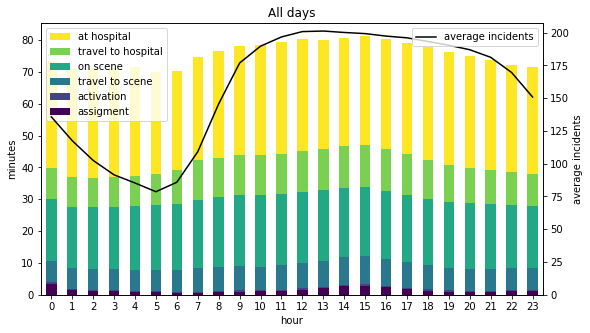

In [12]:
fig = plt.figure(figsize=(9,5))
ax1 = fig.add_subplot(111)

cmap = cm.get_cmap('viridis')
cols = [m + '_mean' for m in resptime_cols]
(df_time_of_day[cols]/60).plot.bar(ax=ax1, cmap=cmap, stacked=True, rot=0)
ax1.set_ylabel('minutes')
ax1.set_ylim(bottom=0)

handles, _ = ax1.get_legend_handles_labels()
ax1.legend(handles[::-1],
           [x.replace('_time_mean', '').replace('_',' ') for x in reversed(cols)],
           loc=2)

ax2 = ax1.twinx()
df_time_of_day.average_incidents.plot(ax=ax2, c='k', label='average incidents')
ax2.set_ylabel('average incidents')
ax2.set_title('All days')
ax2.set_ylim(bottom=0)
ax2.legend(loc=1)
plt.show()

**Note:** Response time peaks at 3pm, not at rush hours. Average number of incidents remains stable during the day. Both dispatch time and travel time go up on peak time, looks like dispatch time goes up more in relative and absolute terms.

In [13]:
df_time_of_day_weekend = df.groupby(['weekend','hour'])[resptime_cols]\
        .agg(['mean','count'])
df_time_of_day_weekend.columns = ['_'.join(col).strip() for col in df_time_of_day_weekend.columns.values]
df_time_of_day_weekend.rename(columns={'assigment_time_count':'total_incidents'}, inplace=True)
df_time_of_day_weekend['average_incidents'] = 0
df_time_of_day_weekend.loc[False, 'average_incidents'] = (df_time_of_day_weekend.loc[False, 'total_incidents']/\
                                                          (5*df.INCIDENT_DATETIME.dt.date.nunique())).values
df_time_of_day_weekend.loc[True, 'average_incidents'] = (df_time_of_day_weekend.loc[True, 'total_incidents']/\
                                                         (2*df.INCIDENT_DATETIME.dt.date.nunique())).values
df_time_of_day_weekend.head()

assigment_time_mean  total_incidents  activation_time_mean  \
weekend hour                                                               
False   0              202.725697           197865             21.530636   
        1               59.055057           166354             21.874864   
        2               53.155541           142901             20.144187   
        3               45.716435           125234             19.209789   
        4               38.639283           116105             19.171308   

              activation_time_count  travel_to_scene_time_mean  \
weekend hour                                                     
False   0                    197661                 391.630200   
        1                    166171                 377.281180   
        2                    142738                 378.382120   
        3                    125097                 378.463992   
        4                    115978                 380.215256   

              travel_to_scene_time_count  on_scene_time_mean  \
weekend hour                                                   
False   0                         197661         1153.865255   
        1                         166171         1147.011091   
        2                         142738         1152.904461   
        3                         125097         1175.042981   
        4                         115978         1203.399878   

              on_scene_time_count  travel_to_hospital_time_mean  \
weekend hour                                                      
False   0                  140792                    568.841410   
        1                  121000                    550.962056   
        2                  104858                    546.313093   
        3                   93414                    553.240948   
        4                   86759                    565.608081   

              travel_to_hospital_time_count  at_hospital_time_mean  \
weekend hour                                                         
False   0                            139889            2007.399840   
        1                            119941            2015.560557   
        2                            104180            2044.803211   
        3                             92883            2048.764755   
        4                             86301            2023.546761   

              at_hospital_time_count  average_incidents  
weekend hour                                             
False   0                     139596          18.061616  
        1                     118896          15.185212  
        2                     104147          13.044363  
        3                      92882          11.431675  
        4                      86301          10.598357

#### Plot separating weekends and weekdays

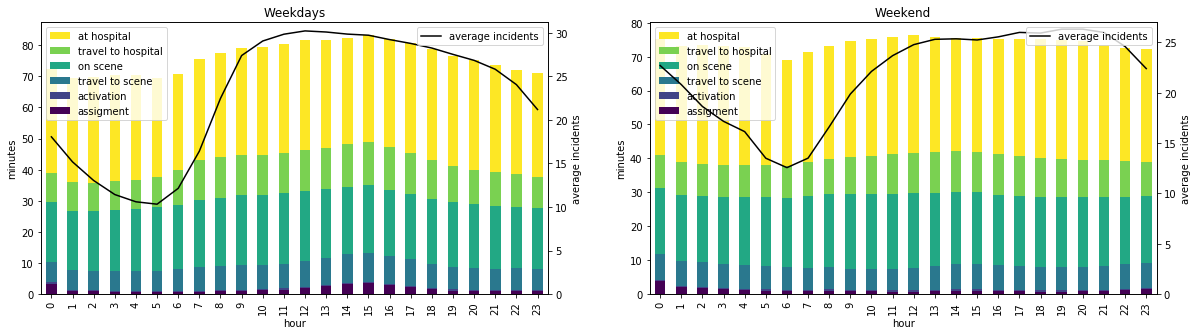

In [17]:
fig = plt.figure(figsize=(20,5))

for i,v in enumerate([False, True]):
    ax1 = fig.add_subplot(1,2,i+1)
    ax1.set_title('Weekend' if v else 'Weekdays')
    
    cols = [m + '_mean' for m in resptime_cols]
    (df_time_of_day_weekend.loc[v,cols]/60).plot.bar(ax=ax1, cmap=cmap, stacked=True)
    ax1.set_ylabel('minutes')
    ax1.set_ylim(bottom=0)
    
    handles, _ = ax1.get_legend_handles_labels()
    ax1.legend(handles[::-1],
           [x.replace('_time_mean', '').replace('_',' ') for x in reversed(cols)],
           loc=2)
    
    ax2 = ax1.twinx()
    
    df_time_of_day_weekend.loc[v,:].average_incidents.plot(ax=ax2, c='k', label='average incidents')
    ax2.set_ylabel('average incidents')
    ax2.set_ylim(bottom=0)
    ax2.legend(loc=1)

plt.show()

**Note:** Plots have different scales, next one has the scales shared. Weekends don't have such a pronounced peak at 3pm, response time is highest at night time around 12am.

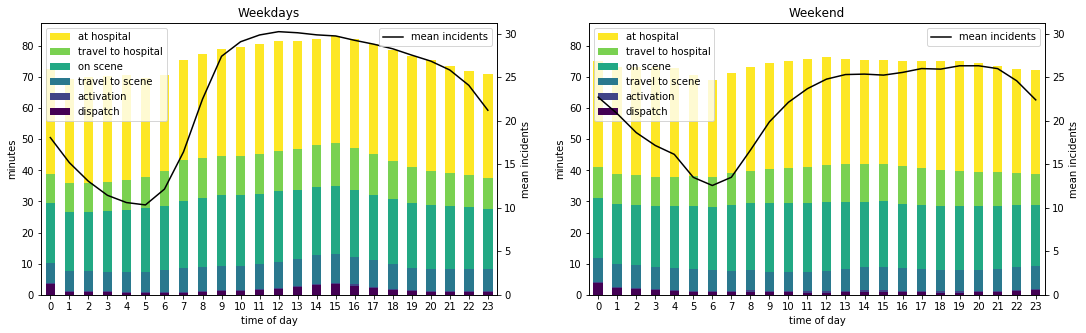

In [32]:
fig = plt.figure(figsize=(18,5))

ax1 = fig.add_subplot(1,2,1)
ax2 = ax1.twinx()
ax3 = fig.add_subplot(1,2,2)
ax4 = ax3.twinx()

ax1.get_shared_y_axes().join(ax1, ax3)
ax2.get_shared_y_axes().join(ax2, ax4)

axes = [[ax1,ax2],[ax3,ax4]]

cols = [m + '_mean' for m in resptime_cols]

for i,v in enumerate([False, True]):
    ax = axes[i][1]
    ax.set_title('Weekend' if v else 'Weekdays')
    
    df_time_of_day_weekend.loc[v,:].average_incidents.plot(ax=ax, c='k', label='mean incidents')
    ax.set_ylabel('mean incidents')
    ax.set_xlabel('time of day')
    ax.set_ylim(bottom=0)
    ax.legend(loc=1)

    ax = axes[i][0]
    #for i, m in enumerate(resptime_cols):
    (df_time_of_day_weekend.loc[v,cols]/60).plot.bar(ax=ax, stacked=True, rot=0, cmap=cmap)
    ax.set_ylabel('minutes')
    ax.set_ylim(bottom=0)
    ax.set_xlabel('time of day')
    
    handles, _ = ax.get_legend_handles_labels()
    ax.legend(handles[::-1],
           [x.replace('_time_mean', '').replace('_',' ').replace('assigment','dispatch') for x in reversed(cols)],
           loc=2)
    
for ax in [item for sublist in axes for item in sublist]:
    plt.setp(ax.get_yticklabels(), visible=True)
    plt.setp(ax.get_yaxis().get_label(), visible=True)
    
plt.savefig('images/time_of_day.png')
plt.show()

In [22]:
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

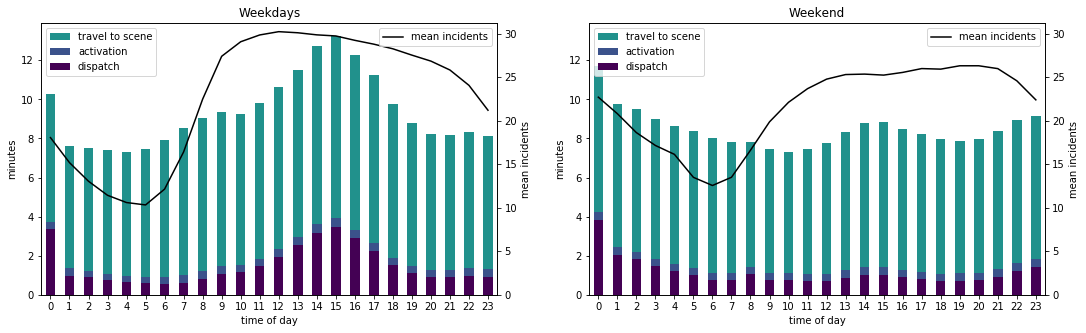

In [31]:
fig = plt.figure(figsize=(18,5))

ax1 = fig.add_subplot(1,2,1)
ax2 = ax1.twinx()
ax3 = fig.add_subplot(1,2,2)
ax4 = ax3.twinx()

ax1.get_shared_y_axes().join(ax1, ax3)
ax2.get_shared_y_axes().join(ax2, ax4)

axes = [[ax1,ax2],[ax3,ax4]]

cols = [m + '_mean' for m in resptime_cols[:3]]

cmap_2 = truncate_colormap(cmap, maxval=.5)

for i,v in enumerate([False, True]):
    ax = axes[i][1]
    ax.set_title('Weekend' if v else 'Weekdays')
    
    df_time_of_day_weekend.loc[v,:].average_incidents.plot(ax=ax, c='k', label='mean incidents')
    ax.set_ylabel('mean incidents')
    ax.set_xlabel('time of day')
    ax.set_ylim(bottom=0)
    ax.legend(loc=1)

    ax = axes[i][0]
    #for i, m in enumerate(resptime_cols):
    (df_time_of_day_weekend.loc[v,cols]/60).plot.bar(ax=ax, stacked=True, rot=0, cmap=cmap_2)
    ax.set_ylabel('minutes')
    ax.set_ylim(bottom=0)
    ax.set_xlabel('time of day')
    
    handles, _ = ax.get_legend_handles_labels()
    ax.legend(handles[::-1],
           [x.replace('_time_mean', '').replace('_',' ').replace('assigment','dispatch') for x in reversed(cols)],
           loc=2)
    
for ax in [item for sublist in axes for item in sublist]:
    plt.setp(ax.get_yticklabels(), visible=True)
    plt.setp(ax.get_yaxis().get_label(), visible=True)
    
plt.savefig('images/time_of_day_2.png')
plt.show()

**Note:** Peak at 3am on weekdays is more prominent here becaus of y-axis scale (now we are showing only times from dispatch to on scene). Weekends response times remain at weekday no-peak levels. Effect of traffic or number of incidents or both.

## Clustering response time by time of day

In [67]:
df_time_of_day_by_zip = df_time_cycles.loc[~df_time_cycles.weekend, ['ZIPCODE', 'hour', 'INCIDENT_RESPONSE_SECONDS_QY']]\
                                        .groupby(['ZIPCODE', 'hour']).mean().reset_index()\
                                        .pivot(index='ZIPCODE', columns='hour', values='INCIDENT_RESPONSE_SECONDS_QY')
df_time_of_day_by_zip.head()

hour,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
ZIPCODE,,,,,,,,,,,,,,,,,,,,,
83.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,617.000000,NaN,420.000000,...,NaN,NaN,395.000000,1058.000000,774.500000,1024.000000,418.000000,682.000000,NaN,NaN
10000.0,649.777778,495.750000,816.000000,396.600000,NaN,466.000000,484.375000,448.000000,566.642857,568.375000,...,1079.857143,1300.404255,1195.812500,1052.227273,710.428571,581.875000,569.884615,652.190476,719.300000,409.400000
10001.0,488.307730,449.501754,479.021171,417.165082,401.134062,398.491457,439.350711,496.066002,549.284871,631.407968,...,980.518380,1009.735959,893.271171,793.685750,660.546368,559.178954,501.992106,474.662423,486.545083,483.191674
10002.0,416.756550,418.589870,398.197143,373.126761,379.888496,370.435185,372.786280,420.992357,416.782837,463.279402,...,795.537247,846.788773,750.549730,628.447805,533.125835,499.931197,459.720188,446.600151,452.049692,451.343311
10003.0,393.439812,413.847687,387.031353,381.281008,357.071096,342.093445,353.733170,408.678245,417.414590,479.681967,...,750.683028,756.382612,677.431140,570.657756,524.023936,454.297256,415.267768,413.598857,413.719608,436.801457


In [68]:
print(df_time_of_day_by_zip.shape)
df_time_of_day_by_zip.dropna(inplace=True)
print(df_time_of_day_by_zip.shape)

(235, 24)
(192, 24)


3 more Zip Codes dropped than before

In [69]:
df_time_of_day_by_zip = ((df_time_of_day_by_zip.T - df_time_of_day_by_zip.mean(axis=1))/df_time_of_day_by_zip.std(axis=1)).T
df_time_of_day_by_zip.head()

hour,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
ZIPCODE,,,,,,,,,,,,,,,,,,,,,
10001.0,-0.645440,-0.846828,-0.693634,-1.014643,-1.097837,-1.111552,-0.899508,-0.605178,-0.328992,0.097194,...,1.908941,2.060569,1.456162,0.939353,0.248411,-0.277646,-0.574424,-0.716254,-0.654588,-0.671990
10002.0,-0.678018,-0.665349,-0.806272,-0.979521,-0.932794,-0.998121,-0.981874,-0.648746,-0.677836,-0.356523,...,1.939540,2.293713,1.628654,0.784871,0.126150,-0.103241,-0.381118,-0.471784,-0.434125,-0.439007
10003.0,-0.733141,-0.569092,-0.784656,-0.830880,-1.025492,-1.145890,-1.052324,-0.610647,-0.540419,-0.039881,...,2.138568,2.184384,1.549730,0.691430,0.316563,-0.243937,-0.557676,-0.571092,-0.570121,-0.384577
10004.0,-0.345891,-0.428810,-0.841336,-1.042898,-0.791278,-1.113536,-1.204411,-1.002200,-0.679717,-0.224431,...,1.864039,2.205371,1.181175,1.096672,0.274411,-0.063359,-0.482576,-0.609141,-0.392780,-0.633046
10005.0,-0.791646,-0.864584,-1.024916,-0.452053,-0.998210,-0.984670,-1.102322,-0.975819,-0.688920,-0.156479,...,1.701907,1.408617,1.390837,1.199255,0.365974,-0.227813,-0.493995,-0.837803,-0.425745,-0.349477


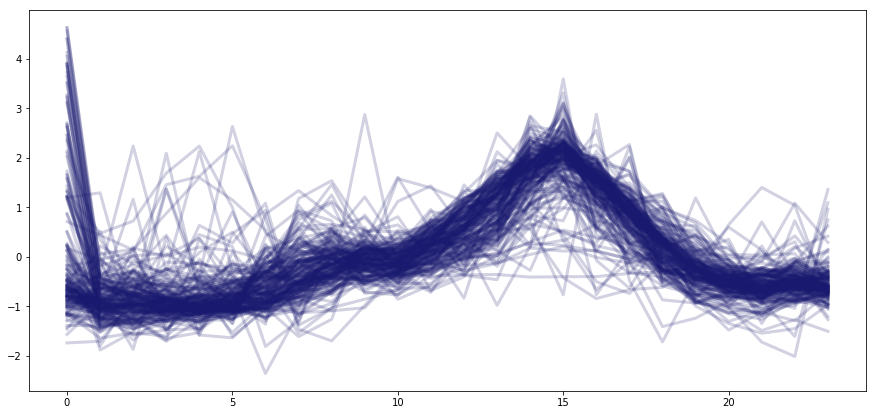

In [70]:
fig = plt.figure(figsize=(15,7))
ax = fig.add_subplot(111)

data_columns = df_time_of_day_by_zip.columns

for ind, row in df_time_of_day_by_zip.iterrows():
    ax.plot(data_columns, row.values, color='midnightblue', alpha=0.2, lw=3)

**Note:** Doesn't look like clustering would be very helpfull. Overall most Zip Codes follow the same time-of-day pattern on weekdays. One useful thing could be to identify the Zip Codes that have the weird spike in response time at 12am, but it is likely a shift or data issue.

In [74]:
#Number of clusters
nc = 4

#cluster with kmeans
km = KMeans(n_clusters=nc, random_state=444).fit(df_time_of_day_by_zip)

#Add to dataframe
df_time_of_day_by_zip['kmeans'] = km.labels_ + 1

km.labels_.shape

(192,)

In [75]:
df_time_of_day_by_zip.index = df_time_of_day_by_zip.index.astype(int)
zips.ZIPCODE = zips.ZIPCODE.astype(int)

df_time_of_day_by_zip_shp = zips.merge(df_time_of_day_by_zip, left_on='ZIPCODE', right_index=True, how='left')

#Add 0 for the zipcodes that were not clustered
df_time_of_day_by_zip_shp.fillna(0, inplace=True)

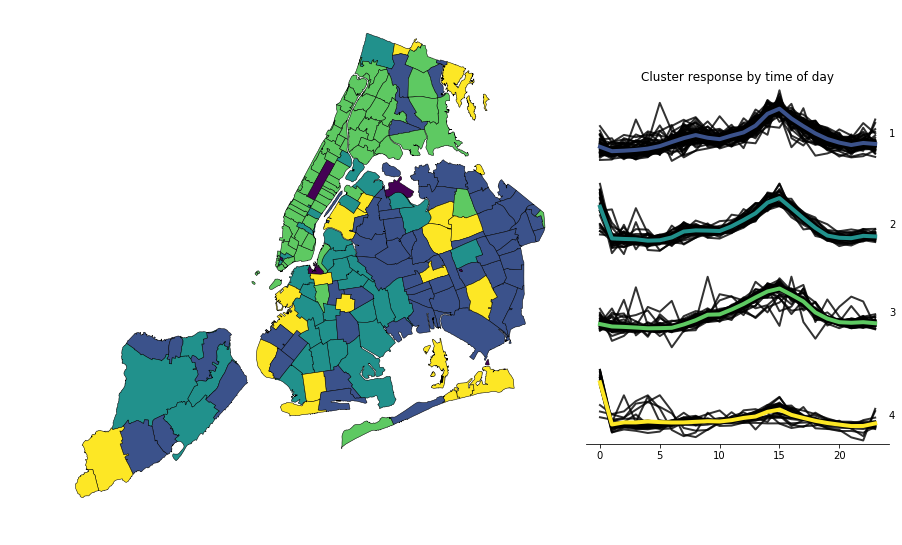

In [76]:
#Plot a map and the clustered time series
cmap = cm.get_cmap('viridis')
cmap.set_bad((1, 1, 1, 1))
fig = plt.figure(figsize=(15,10))

for i in range(nc):
    
    cluster = df_time_of_day_by_zip.loc[df_time_of_day_by_zip.kmeans == (i+1),data_columns]
    
    ax = plt.subplot2grid((nc+2, 8), (i+1, 5), colspan=3)
    
    if i == 0:
        ax.set_title("Cluster response by time of day")
    
    for row, values in cluster.iterrows():
        
        ax.plot(data_columns, values, 'k-', alpha=0.8, lw=2)
        
    ax.plot(data_columns, cluster.mean(axis=0).values, '-', lw=4, color=cmap((i+1)/nc))
    
    ax.annotate(s='{}'.format(i+1), xy=(ax.get_xlim()[1],0))

    ax.axis('off')
    
    if i == nc-1:
        ax.axis('on')
        ax.spines['right'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.set_yticks([])

ax = plt.subplot2grid((nc+2, 8), (0, 0), colspan=5, rowspan=9)

df_time_of_day_by_zip_shp.plot(column='kmeans', ax=ax, cmap=cmap, edgecolor='k', lw=0.5)

ax.axis('off')

plt.show()

**Note:** Not very useful I think.

## Initial vs actual severity level

In [21]:
severity_cols = ['INITIAL_SEVERITY_LEVEL_CODE','FINAL_SEVERITY_LEVEL_CODE']

df_severity = df.loc[:,severity_cols + resptime_cols]
df_severity['SEVERITY_LEVEL_DIFFERENCE'] =  df_severity['INITIAL_SEVERITY_LEVEL_CODE']-df_severity['FINAL_SEVERITY_LEVEL_CODE']
df_severity.head()

,INITIAL_SEVERITY_LEVEL_CODE,FINAL_SEVERITY_LEVEL_CODE,INCIDENT_RESPONSE_SECONDS_QY,INCIDENT_TRAVEL_TM_SECONDS_QY,DISPATCH_RESPONSE_SECONDS_QY,SEVERITY_LEVEL_DIFFERENCE
0,4,4,797.0,696.0,101,0
1,3,3,851.0,792.0,59,0
2,1,1,429.0,400.0,29,0
3,6,6,828.0,772.0,56,0
4,5,5,856.0,824.0,32,0


In [22]:
df_severity_crosstab = pd.crosstab(df_severity.INITIAL_SEVERITY_LEVEL_CODE, df_severity.FINAL_SEVERITY_LEVEL_CODE)
#Scale by rows = percentage relative to the initial severity level
df_severity_crosstab = (df_severity_crosstab.T / df_severity_crosstab.sum(axis=1)).T
df_severity_crosstab

FINAL_SEVERITY_LEVEL_CODE,1,2,3,4,5,6,7,8
INITIAL_SEVERITY_LEVEL_CODE,,,,,,,,
1,0.981635,0.008274,0.002439,0.003979,0.001422,0.001600,0.000632,0.000020
2,0.022700,0.968739,0.004430,0.001973,0.000600,0.001216,0.000249,0.000093
3,0.004957,0.034054,0.955272,0.001673,0.001912,0.001351,0.000755,0.000025
4,0.004226,0.038515,0.027750,0.913400,0.007684,0.005591,0.002729,0.000104
5,0.001168,0.012540,0.028961,0.011691,0.942750,0.000835,0.002023,0.000031
6,0.001559,0.020170,0.036685,0.015847,0.012829,0.909135,0.003601,0.000175
7,0.000942,0.008564,0.013445,0.037981,0.016697,0.009536,0.912762,0.000074
8,0.001199,0.097209,0.009814,0.013412,0.025624,0.005016,0.008342,0.839385
9,0.043478,0.159420,0.144928,0.347826,0.173913,0.072464,0.043478,0.014493


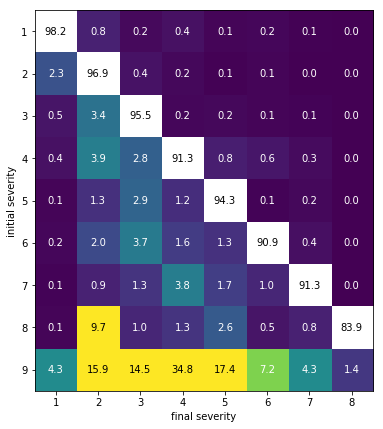

In [23]:
cross_temp = df_severity_crosstab.copy()
cross_temp.values[[np.arange(cross_temp.shape[1])]*2] = np.nan
cut = 0.09

cmap = cm.get_cmap('viridis')
cmap.set_bad((1, 1, 1, 1))

ax = plt.figure(figsize=(7,7)).add_subplot(111)
cax = ax.imshow(cross_temp, cmap=cmap, vmax=cut)
#plt.colorbar(cax)

ax.set_xticks(range(len(df_severity_crosstab.columns)))
ax.set_xticklabels(df_severity_crosstab.columns)
ax.set_xlabel('final severity')

ax.set_yticks(range(len(df_severity_crosstab.index)))
ax.set_yticklabels(df_severity_crosstab.index)
ax.set_ylabel('initial severity')

for i in range(len(df_severity_crosstab.index)):
    for j in range(len(df_severity_crosstab.columns)):
        text = ax.text(j, i, '{:.1f}'.format(100*df_severity_crosstab.iloc[i, j]),
                       ha="center", va="center", color="k" if df_severity_crosstab.iloc[i, j]>cut else "w")

ax.grid(False)
plt.show()

**Note:** Higher initial severity levels (lower number) have higher accuracy. Most corrections are to increase the severity level. *What does initial severity 9 mean?*

Percentage of mis-classified incidents:

In [24]:
(df_severity['SEVERITY_LEVEL_DIFFERENCE'] != 0).sum() / len(df_severity) * 100

6.4445743189958593

Percentage of mis-classified incidents that get it's severity level increased:

In [25]:
(df_severity['SEVERITY_LEVEL_DIFFERENCE'] > 0).sum() / (df_severity['SEVERITY_LEVEL_DIFFERENCE'] != 0).sum() * 100

89.088182459375986

## # of Incidents vs Response time

In [36]:
df['INCIDENT_DATE'] = df.INCIDENT_DATETIME.dt.date

In [9]:
df_by_date = df.groupby(['INCIDENT_DATE'])['INCIDENT_RESPONSE_SECONDS_QY'].agg(['mean', 'count'])
df_by_date.head()

,mean,count
INCIDENT_DATE,,
2013-01-01,845.846104,4633
2013-01-02,634.914999,3647
2013-01-03,712.741474,3841
2013-01-04,757.439648,3753
2013-01-05,507.700272,3313


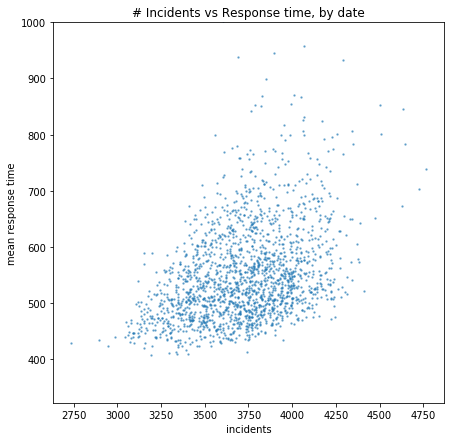

In [29]:
fig, ax = plt.subplots(figsize=(7,7))

df_by_date.plot.scatter(x='count', y='mean', s=2, alpha=0.5, ax=ax)

ax.set_ylim(top=1000)
ax.set_xlabel('incidents')
ax.set_ylabel('mean response time')
ax.set_title('# Incidents vs Response time, by date')

plt.show()

In [37]:
df_by_date_boro = df.groupby(['BOROUGH','INCIDENT_DATE'])['INCIDENT_RESPONSE_SECONDS_QY'].agg(['mean', 'count'])
df_by_date_boro['mean'] = df_by_date_boro['mean']/60
df_by_date_boro.head()

mean  count
BOROUGH  INCIDENT_DATE                  
b'BRONX' 2013-01-01     14.051587   1029
         2013-01-02     11.443202    863
         2013-01-03     13.624908    904
         2013-01-04     19.183559    886
         2013-01-05      9.931341    820

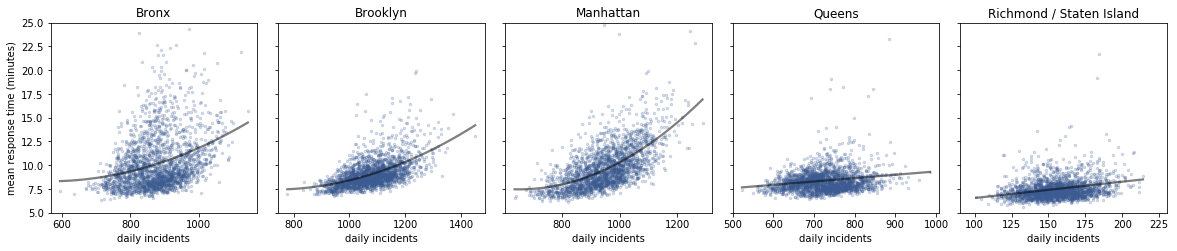

In [87]:
fig, axes = plt.subplots(ncols=5, figsize=(20,3.5), sharey=True)
plt.subplots_adjust(wspace=0.1)

boros = list(df_by_date_boro.index.get_level_values(0).unique())
boros.remove(b'UNKNOWN')

for i, b in enumerate(boros):
    ax = axes[i]
    #ax.set(xscale='log', yscale='log')
    boro = df_by_date_boro.loc[(b, slice(None)), :]
    sns.regplot(x='count', y='mean', ax=ax, data=boro, ci=None, truncate=True, order=(2 if i<=2 else 1),
                scatter_kws={'alpha':0.2, 'color':sns.xkcd_rgb["denim blue"], 's':6},
                line_kws={'alpha':0.5, 'color':'k'})
    #p.set_xticklabels(p.get_xticklabels(), rotation=90)
    #df_by_date_boro.loc[(b, slice(None)), :].plot.scatter(x='count', y='mean', s=1, alpha=0.5, ax=ax)
    ax.set_ylim(bottom=5, top=25)
    ax.set_xlabel('daily incidents')
    ax.set_title(bytes.decode(b).title())
    if i == 0:
        ax.set_ylabel('mean response time (minutes)')
    else:
        ax.set_ylabel('')
        
    if i == 4:
        ax.set_xlim(left=90, right=230)

plt.savefig('images/incidents_vs_resptime.png')
plt.show()